# MAST30034 Applied Data Science Project 2
## Analysis Notebook

In [10]:
# Import libraries
from pyspark.sql import SparkSession, functions as F, DataFrame
from pyspark.sql.functions import isnan, when, count, col

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from turtle import title

import geopandas as gpd
import folium

# Create spark session
spark = (
    SparkSession.builder.appName("Analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

# Read in preprocessed data
data = spark.read.parquet('../data/curated/final_data.parquet')
sf = gpd.read_file("../data/external/shapefile/SA2_2021_AUST_GDA2020.shp")
external_data = pd.read_parquet('../data/curated/external_data.parquet')
data_pd = pd.read_parquet('../data/curated/final_data.parquet')

In [11]:
data

SA2_CODE_2021,postcode,consumer_id,user_id,merchant_abn,dollar_value,order_id,order_datetime,name,tags,take rate,revenue level,consumer_name,address,gender,SA2_NAME_2021,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_mortgage_repay_monthly,Median_age_persons,Median_tot_hhd_inc_weekly,Average_household_size,Year_12_Highest_Level_of_School,Did_Not_Attend_School,TOT_P_P,state
127031524,2173,299982,18037,84703983173,38.25440662197301,f39ef40a-3f9e-46c...,2021-08-20,Amet Consulting,[computer program...,2.31,c,John Ochoa,8868 Jefferson Ports,Male,Holsworthy - Watt...,1027.0,495.0,2275.0,35.0,2463.0,3.0999999046325684,10487.0,107.0,21129.0,NSW
127031524,2173,299982,18037,90578415511,116.33739544829827,33863232-af54-416...,2021-08-21,A Scelerisque Fou...,"[furniture, home...",5.95,a,John Ochoa,8868 Jefferson Ports,Male,Holsworthy - Watt...,1027.0,495.0,2275.0,35.0,2463.0,3.0999999046325684,10487.0,107.0,21129.0,NSW
127031524,2173,299982,18037,84703983173,124.92450144172797,53cd8ac0-fae9-49e...,2021-08-19,Amet Consulting,[computer program...,2.31,c,John Ochoa,8868 Jefferson Ports,Male,Holsworthy - Watt...,1027.0,495.0,2275.0,35.0,2463.0,3.0999999046325684,10487.0,107.0,21129.0,NSW
127031524,2173,299982,18037,74155418313,270.1893630541408,e7ba7f7f-9be9-42d...,2021-08-19,Egestas Ligula Corp.,[motor vehicle su...,3.61,b,John Ochoa,8868 Jefferson Ports,Male,Holsworthy - Watt...,1027.0,495.0,2275.0,35.0,2463.0,3.0999999046325684,10487.0,107.0,21129.0,NSW
127031524,2173,299982,18037,86578477987,89.87043911278471,93ca6960-14e4-4df...,2021-08-19,Leo In Consulting,"[watch, clock, ...",6.43,a,John Ochoa,8868 Jefferson Ports,Male,Holsworthy - Watt...,1027.0,495.0,2275.0,35.0,2463.0,3.0999999046325684,10487.0,107.0,21129.0,NSW
127031524,2173,299982,18037,94455880010,80.04173617818067,09311fb5-0848-4bf...,2021-08-14,Nunc Sit LLC,[computer program...,6.33,a,John Ochoa,8868 Jefferson Ports,Male,Holsworthy - Watt...,1027.0,495.0,2275.0,35.0,2463.0,3.0999999046325684,10487.0,107.0,21129.0,NSW
127031524,2173,299982,18037,21772962346,132.65608217056615,07e68a50-b11d-44d...,2021-07-15,Purus Gravida Sag...,[florists supplie...,6.63,a,John Ochoa,8868 Jefferson Ports,Male,Holsworthy - Watt...,1027.0,495.0,2275.0,35.0,2463.0,3.0999999046325684,10487.0,107.0,21129.0,NSW
127031524,2173,299982,18037,79248381674,258.0740387738063,72854dc8-f226-453...,2021-08-16,Tellus Non LLC,"[furniture, home...",3.29,b,John Ochoa,8868 Jefferson Ports,Male,Holsworthy - Watt...,1027.0,495.0,2275.0,35.0,2463.0,3.0999999046325684,10487.0,107.0,21129.0,NSW
127031524,2173,299982,18037,49891706470,26.814908315884942,6862f731-20bd-40c...,2021-08-27,Non Vestibulum In...,[tent and awning ...,5.80,a,John Ochoa,8868 Jefferson Ports,Male,Holsworthy - Watt...,1027.0,495.0,2275.0,35.0,2463.0,3.0999999046325684,10487.0,107.0,21129.0,NSW
127031524,2173,299982,18037,84703983173,31.468692823908174,e2acdcbb-2cc8-42e...,2021-08-27,Amet Consulting,[computer program...,2.31,c,John Ochoa,8868 Jefferson Ports,Male,Holsworthy - Watt...,1027.0,495.0,2275.0,35.0,2463.0,3.0999999046325684,10487.0,107.0,21129.0,NSW


### **1. Outlier Analysis**

Questions:
* If you found NULL values after you joined the datasets, what did you do with them? How many were there?

    * After joining the datasets, there were 750332 null values in the SA2 dataset and 182 in the origninal dataset, these comprised of approximatley 2% of the total dataset. for null values in the SA2 dataset, the postcodes were used to determine which state the purchase came from. then averaging over all the data in that state the other columns were populated.

* Was there any missing data that shouldn’t be missing after joining to your externaldataset? If anything was missing, how much was there and what did you do about it?

    * There was only 182 rows of missing data once joined, due to the extremely low number and the fact that the whole purchase was null, they were removed.

* If you decided to omit outliers, what does the distribution look like prior and after?


In [12]:
# data.limit(5)
# data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns])

#### 1.1 Customer Details

- **SA2_CODE_2021 / SA2_NAME_2021**: For null values in the SA2 dataset, the postcodes were used to determine which state the purchase came from. then averaging over all the data in that state the other columns were populated (see `null_imputation.py`).

- **Postcode**: Remove all instances in a null postcode as there is not way to determine the location of the purchase with the postcode. According to AusPost, all post between 1000-9999 are valid, thus we will keep all.

-  **Gender**: No outliers found.

In [13]:
data = data.na.drop(subset=["postcode"])

print(data.agg({'postcode': 'min'}))
print(data.agg({'postcode': 'max'}))

data.groupBy('gender').count()

+-------------+
|min(postcode)|
+-------------+
|         1001|
+-------------+



+-------------+
|max(postcode)|
+-------------+
|         9999|
+-------------+



gender,count
Undisclosed,1623279
Female,7119165
Male,7284138


#### 1.2 Order Details

-  **Order Date**: Based on the output all values are in 2021-2022. 
    - The latest snapshot was obtained on 2022-08-28, but contains orders placed after the date, which is illogical, thus we will remove orders with order date after this date
    


- **ABN**: All ABNs are 11 digits long, thus we will verify this.

- **Dollar Value**:
    - Instances < $0.05 seem unreasonable due the the limited things you can buy for 5c, thus they will be removed from the dataset.

    - Instances > $50,000 come from anitque shops or jewelry shops and thus is plausible for the individuals to be spending large amounts of money. 

In [14]:
data = data.where(col('order_datetime') <= '2022-08-28')

In [15]:
print(data.agg({'order_datetime': 'min'}))
print(data.agg({'order_datetime': 'max'}))

print(data.agg({'merchant_abn': 'min'}))
print(data.agg({'merchant_abn': 'max'}))

print(data.agg({'dollar_value': 'min'}))
print(data.agg({'dollar_value': 'max'}))

+-------------------+
|min(order_datetime)|
+-------------------+
|         2021-02-28|
+-------------------+



+-------------------+
|max(order_datetime)|
+-------------------+
|         2022-08-28|
+-------------------+



+-----------------+
|min(merchant_abn)|
+-----------------+
|      10023283211|
+-----------------+



+-----------------+
|max(merchant_abn)|
+-----------------+
|      99990536339|
+-----------------+



+--------------------+
|   min(dollar_value)|
+--------------------+
|9.756658099412162E-8|
+--------------------+



+------------------+
| max(dollar_value)|
+------------------+
|105193.88578925544|
+------------------+



In [16]:
# Check instances < $0.05
data.where(col("dollar_value") <= 0.05).limit(10)

SA2_CODE_2021,postcode,consumer_id,user_id,merchant_abn,dollar_value,order_id,order_datetime,name,tags,take rate,revenue level,consumer_name,address,gender,SA2_NAME_2021,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_mortgage_repay_monthly,Median_age_persons,Median_tot_hhd_inc_weekly,Average_household_size,Year_12_Highest_Level_of_School,Did_Not_Attend_School,TOT_P_P,state
212041460,3174,705006,10039,94455880010,0.046712828714520364,cc8fef8c-15b0-4c6...,2022-08-14,Nunc Sit LLC,[computer program...,6.33,a,Stephanie Walker,56760 Dougherty Road,Female,Noble Park - West,586.0,346.0,1700.0,36.0,1399.0,2.9000000953674316,9422.0,924.0,19591.0,VIC
402041046,5106,1299545,2015,69703285964,0.00328598936319902,16737e5c-430d-47b...,2021-12-02,Suspendisse Incor...,"[cable, satellit...",5.77,a,Dr. Robert Brown,7254 Clark Course...,Male,Salisbury,530.0,270.0,1246.0,37.0,1071.0,2.5,6085.0,884.0,18594.0,SA
209031212,3099,1437179,15056,17324645993,0.03520826478148184,3a5a30cc-afa0-428...,2021-09-29,Eget Metus In Cor...,[tent and awning ...,5.73,a,Keith Warren,2316 Tiffany Ligh...,Male,Panton Hill - St ...,876.0,300.0,2200.0,48.0,2254.0,2.9000000953674316,2476.0,10.0,5091.0,VIC
127031524,2173,360808,18801,30942453214,0.019899023863320195,6f6c8cbe-849f-453...,2022-07-11,Justo Nec Associates,"[opticians, opti...",6.83,a,Eric Blair,03529 Anne Stream,Male,Holsworthy - Watt...,1027.0,495.0,2275.0,35.0,2463.0,3.0999999046325684,10487.0,107.0,21129.0,NSW
209031212,3759,1181044,22176,29521780474,0.04871460524866421,02bc0ffd-a305-465...,2022-03-23,At Sem Corp.,"[cable, satellit...",5.93,a,Marcus Obrien,289 Black Point S...,Male,Panton Hill - St ...,876.0,300.0,2200.0,48.0,2254.0,2.9000000953674316,2476.0,10.0,5091.0,VIC
212041460,3174,1291995,16272,94455880010,0.01974700837102088,a63d81ee-4d13-462...,2022-06-30,Nunc Sit LLC,[computer program...,6.33,a,Latasha Oliver,22357 Bailey Drive,Female,Noble Park - West,586.0,346.0,1700.0,36.0,1399.0,2.9000000953674316,9422.0,924.0,19591.0,VIC
126021498,2111,13606,8312,46804135891,0.023547857838012862,9a12676b-3d31-4df...,2021-11-24,Suspendisse Dui C...,"[opticians, opti...",2.93,c,Diane Nelson,0490 Darrell Broo...,Female,Gladesville - Hun...,1198.0,460.0,3000.0,40.0,2315.0,2.4000000953674316,9359.0,79.0,15456.0,NSW
206061138,3142,428481,4868,60978195146,0.02158004959977744,36b21303-6e46-478...,2021-07-07,Lobortis Tellus C...,[shoe shops],1.44,c,Savannah Hendricks,8629 Jason Island...,Female,Toorak,1428.0,490.0,3146.0,47.0,2538.0,2.0999999046325684,9130.0,15.0,12953.0,VIC
206061138,3142,428481,4868,46804135891,0.039835786569638654,39599b89-5013-498...,2022-08-20,Suspendisse Dui C...,"[opticians, opti...",2.93,c,Savannah Hendricks,8629 Jason Island...,Female,Toorak,1428.0,490.0,3146.0,47.0,2538.0,2.0999999046325684,9130.0,15.0,12953.0,VIC
401021008,5153,302375,21578,35733444320,0.03774101579955414,f560648f-5e31-457...,2021-09-25,Arcu Ac Limited,"[watch, clock, ...",3.41,b,Patricia Logan,5341 Travis Camp ...,Female,Mount Barker Surr...,820.0,305.0,1522.0,43.0,1784.0,2.5999999046325684,2847.0,3.0,6825.0,SA


In [17]:
# Number of instances < $0.05
data.where(col("dollar_value") <= 0.05).count()

5154

In [18]:
# Remove instances < $0.05
data  = data.where(col('dollar_value') >= 0.05)

In [19]:
# Check instances > $50000
data.where(col("dollar_value") >= 50000).limit(10)

SA2_CODE_2021,postcode,consumer_id,user_id,merchant_abn,dollar_value,order_id,order_datetime,name,tags,take rate,revenue level,consumer_name,address,gender,SA2_NAME_2021,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_mortgage_repay_monthly,Median_age_persons,Median_tot_hhd_inc_weekly,Average_household_size,Year_12_Highest_Level_of_School,Did_Not_Attend_School,TOT_P_P,state
null,6913,1380769,18916,83199298021,59223.92657075801,61fe4fa3-f199-4a1...,2021-08-08,Ligula Elit Preti...,[antique shops - ...,4.82,b,Tracy Short,1636 Davis Plains,Female,Western Austraia,873.8307459690882,273.0418213751717,1546.8966254544807,41.89099140227113,1687.1425933061068,2.457619332208109,3608.7203534649348,38.97269925556913,8296.519378399486,WA
509021242,6484,27622,3101,91880575299,105193.88578925544,2ab65c8f-11b2-41c...,2021-04-17,At Foundation,[antique shops - ...,3.40,b,Christopher Roberson,6757 Reginald Haven,Male,Mukinbudin,853.0,133.0,719.0,47.0,1286.0,2.0999999046325684,954.0,5.0,3005.0,WA
507051191,6173,649212,10447,82999039227,58176.53006300072,785f5625-5b2e-4f2...,2021-07-12,null,null,null,null,Christopher Stevens,90816 Christensen...,Male,Singleton - Golde...,938.0,365.0,1950.0,33.0,2267.0,3.0,8829.0,31.0,22178.0,WA
212011551,3813,184299,22239,67264251405,51876.637563877644,09206be9-492c-414...,2021-10-19,Elit Dictum Eu Fo...,[art dealers and ...,6.40,a,George Mendoza,156 Alexander Vil...,Male,Pakenham - South ...,674.0,335.0,1517.0,35.0,1235.0,2.299999952316284,2405.0,52.0,6439.0,VIC
null,1212,1319595,23700,11590404675,65660.03308418578,1d8f2322-d8c8-46c...,2021-08-26,Arcu Sed PC,[antique shops - ...,4.19,b,Angela Harris,572 Shannon Plaza,Undisclosed,New South Wales,857.9544855336248,405.5074734118145,2097.357372208434,41.54326295873019,1851.6818809676993,2.5610256730328604,5810.873033461334,97.19992632726866,12293.502117124777,NSW
307011177,4454,882166,5606,99989036621,56552.39444305644,63e74dd2-a1e4-42b...,2021-10-17,null,null,null,null,Mercedes Liu,18523 Bradford Ju...,Undisclosed,Roma Surrounds,770.0,155.0,1114.0,42.0,1436.0,2.5,1802.0,20.0,5989.0,QLD
108041165,2441,686290,3580,79246172899,58127.848667879116,71d944b3-c623-4c4...,2022-06-13,null,null,null,null,Leon Howard,2439 Jason Loop,Male,Port Macquarie Su...,632.0,300.0,1668.0,50.0,1334.0,2.5,1730.0,6.0,5301.0,NSW
314021579,4509,406485,14942,65655213781,55454.88910234865,9fbff07d-aeea-470...,2022-08-26,null,null,null,null,Phillip Wallace,378 Miller Vista ...,Undisclosed,North Lakes,885.0,420.0,1950.0,35.0,2092.0,2.9000000953674316,11271.0,54.0,23030.0,QLD
314021578,4509,406485,14942,65655213781,55454.88910234865,9fbff07d-aeea-470...,2022-08-26,null,null,null,null,Phillip Wallace,378 Miller Vista ...,Undisclosed,Mango Hill,959.0,400.0,2000.0,31.0,2145.0,3.0,7248.0,47.0,14921.0,QLD
407021155,5271,1253388,15504,83199298021,57996.7495260236,dfd47864-2440-4de...,2022-06-19,Ligula Elit Preti...,[antique shops - ...,4.82,b,John Diaz,13195 Cole Spring...,Male,Naracoorte Surrounds,874.0,150.0,900.0,44.0,1632.0,2.5,885.0,11.0,2395.0,SA


### **2. Transaction Analysis**

#### 2.1 Transaction Location

<AxesSubplot:title={'center':'Top 10 Merchants by Transaction Volume'}, ylabel='merchant_abn'>

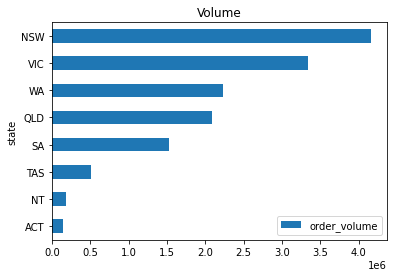

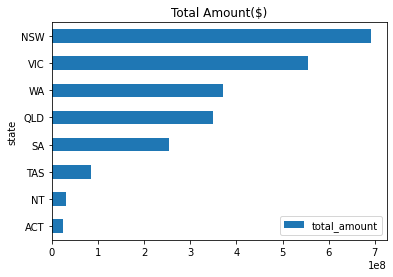

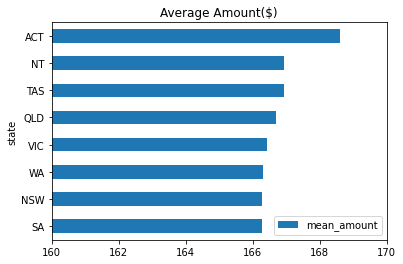

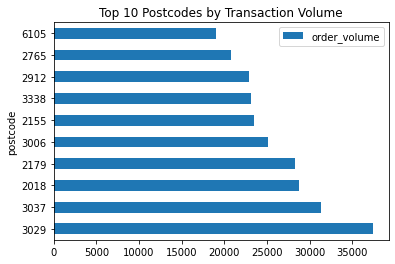

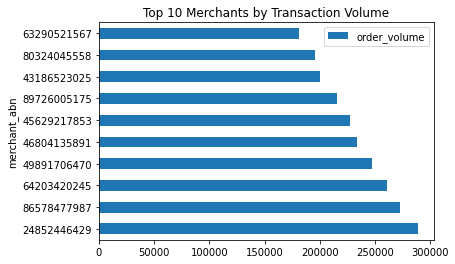

In [20]:
# Aggregate Data
# By State
transaction_by_state = data \
                    .groupBy("state") \
                    .agg(
                        F.mean("dollar_value").alias("mean_amount"),
                        F.sum("dollar_value").alias("total_amount"),
                        F.count("order_id").alias("order_volume")
                    ) \
                    .orderBy("state") \
                    .toPandas()

# By Postcode
transaction_by_postcode = data \
                    .groupBy("postcode") \
                    .agg(
                        F.mean("dollar_value").alias("mean_amount"),
                        F.sum("dollar_value").alias("total_amount"),
                        F.count("order_id").alias("order_volume")
                    ) \
                    .orderBy("postcode") \
                    .toPandas()

# By Merchant
transaction_by_merchant = data \
                    .groupBy("merchant_abn") \
                    .agg(
                        F.mean("dollar_value").alias("mean_amount"),
                        F.sum("dollar_value").alias("total_amount"),
                        F.count("order_id").alias("order_volume")
                    ) \
                    .orderBy("merchant_abn") \
                    .toPandas()

# Generate plots
transaction_by_state = transaction_by_state.sort_values(by='order_volume')
transaction_by_state.plot(x='state', y='order_volume', kind="barh", title='Volume')
transaction_by_state = transaction_by_state.sort_values(by='total_amount')
transaction_by_state.plot(x='state', y='total_amount', kind="barh", title='Total Amount($)')
transaction_by_state = transaction_by_state.sort_values(by='mean_amount')
transaction_by_state.plot(x='state', y='mean_amount', kind="barh", xlim=[160,170], title='Average Amount($)')

transaction_by_postcode = transaction_by_postcode.sort_values(by='order_volume', ascending=False)
transaction_by_postcode[:10].plot(x='postcode', y='order_volume', kind="barh", title='Top 10 Postcodes by Transaction Volume')

transaction_by_merchant = transaction_by_merchant.sort_values(by='order_volume', ascending=False)
transaction_by_merchant[:10].plot(x='merchant_abn', y='order_volume', kind="barh", title='Top 10 Merchants by Transaction Volume')

#### 2.2 Transaction Datetime

##### 2.2.1 Time of Year
(All instances are from 2021)

Text(0, 0.5, 'Average Amount')

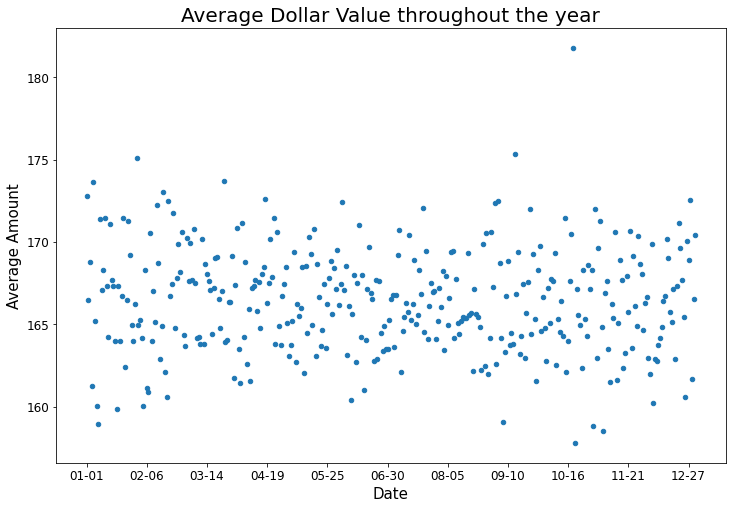

In [21]:
data = data.withColumn('date', F.regexp_replace('order_datetime', r'(\d{4})-', ''))
data = data.withColumn('year', F.regexp_replace('order_datetime', r'(-\d{2}-\d{2})', ''))

# data.groupBy("date").sum('dollar_value')

date_df = data[['date', 'dollar_value']] \
                .groupby('date') \
                .agg(
                    {
                        'dollar_value': 'sum', 
                        'date': 'count'
                    }
                )
date_df = date_df.withColumn('avg_dollar_value', date_df['sum(dollar_value)'] / date_df['count(date)'])
date_df.drop('sum(dollar_value)', 'count(date)')
date_df = date_df.toPandas()

date_df = date_df.sort_values(by = ['date'])
x = date_df['date']
y = date_df['avg_dollar_value']

# plotting
fig, ax = plt.subplots(figsize=(12,8))
time_df = pd.DataFrame({"date": x, "avg_dollar_value":y})
time_df.plot(kind='scatter', x= 'date', y= 'avg_dollar_value', fontsize = 12, ax=ax, legend = False) 
ax.set_title('Average Dollar Value throughout the year', fontsize = 20)
ax.set_xlabel("Date", fontsize = 15)
xticks = ax.get_xticks()
ax.set_xticks(xticks[::len(xticks) // 10])
ax.set_ylabel("Average Amount", fontsize = 15)

##### 2.2.2 Day of the week

Text(0, 0.5, 'Average Amount')

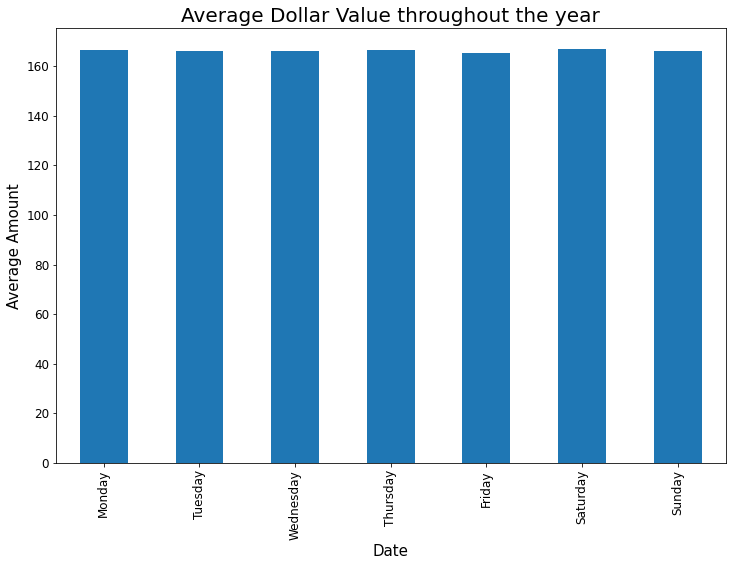

In [22]:
data_pd['order_datetime'] = pd.to_datetime(data_pd['order_datetime'])
data_pd['day_of_week'] = data_pd['order_datetime'].dt.day_name()

date_df = data_pd[['day_of_week', 'dollar_value']] \
                .groupby('day_of_week') \
                .agg(
                    {
                        'dollar_value': 'sum', 
                        'day_of_week': 'count'
                    }
                )

date_df['avg_dollar_value'] = date_df['dollar_value']/date_df['day_of_week']
date_df = date_df.drop(columns = ['dollar_value', 'day_of_week'])
#date_df = date_df.drop('day_of_week_count')
#date_df.rename(columns = {'day_of_week':'count'})
#date_df['count'] = date_df['day_of_week']
#date_df.drop('day_of_week')
#date_df
date_df = date_df.reset_index()
dotw = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
date_df['Date'] = pd.Categorical(date_df['day_of_week'], categories=dotw, ordered=True)
date_df = date_df.sort_values('Date')

x = date_df['day_of_week']
y = date_df['avg_dollar_value']

# plotting
fig, ax = plt.subplots(figsize=(12,8))
time_df = pd.DataFrame({"day_of_week": x, "avg_dollar_value":y})
time_df.plot(kind='bar', x= 'day_of_week', y= 'avg_dollar_value', fontsize = 12, ax=ax, legend = False) 
ax.set_title('Average Dollar Value throughout the year', fontsize = 20)
ax.set_xlabel("Date", fontsize = 15)
xticks = ax.get_xticks()
ax.set_ylabel("Average Amount", fontsize = 15)

#### 2.3 Distribution of Dollar Value

Text(0.5, 1.0, 'Distribution of dollar value')

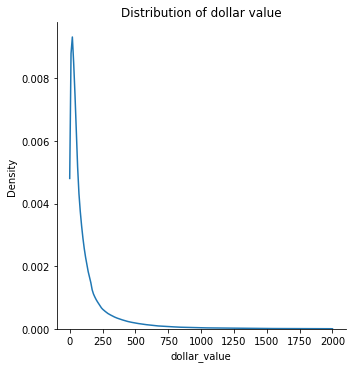

In [23]:
less_than_2000 = data_pd[data_pd['dollar_value']<2000]
sns.displot(less_than_2000, x="dollar_value", kind="kde", cut = 0)
plt.title('Distribution of dollar value')

#### 2.4 Distribution of Merchant Revenue Levels

In [24]:
revenue_level = data.select('revenue level').toPandas()

# Distribution of revenue levels
rv_count = revenue_level.value_counts(normalize=True, sort=False)
rv_count

revenue level
a                0.448950
b                0.288101
c                0.244100
d                0.010030
e                0.008820
dtype: float64

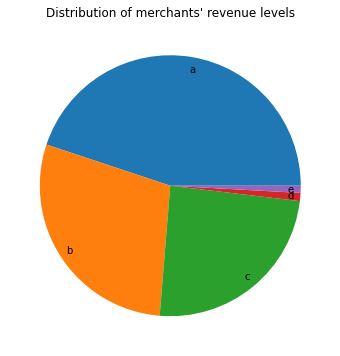

In [25]:
# Plot pie chart for distribution of revenue levels
plt.figure(figsize=(10,6))
plt.pie(rv_count, labels=['a','b','c','d','e'], labeldistance=0.9)
plt.title('Distribution of merchants\' revenue levels')
plt.show()

### **3. Correlation Analysis**

<AxesSubplot:>

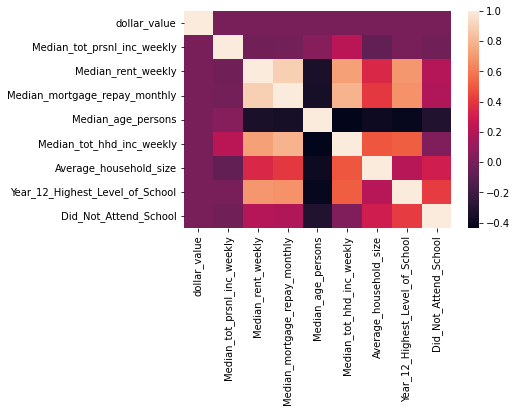

In [26]:
# Select attributes to check correlation with transaction amount
df_corr = data.select('dollar_value', 
                      'Median_tot_prsnl_inc_weekly', 
                      'Median_rent_weekly', 
                      'Median_mortgage_repay_monthly', 
                      'Median_age_persons', 
                      'Median_tot_hhd_inc_weekly', 
                      'Average_household_size', 
                      'Year_12_Highest_Level_of_School', 
                      'Did_Not_Attend_School').toPandas()
                      
# Create heatmap of correlation
sns.heatmap(df_corr.corr())

### **4. Geospatial Analysis**

Removed From Visualisation for Income (Extremely High Household Income): 
- 797979799 - Migratory - Offshore - Shipping (NT)
- 206041507	- Royal Botanic Gardens Victoria (VIC)
- 801011012 - Gooromon (ACT)
- 503021037 - Kings Park (WA)
- 801011111 - Molonglo Corridor (ACT)

In [27]:
data = data.withColumn("take_rate*dollar_value", F.col("take rate")*F.col("dollar_value")/100)
SA2_data = data \
            .groupBy("SA2_CODE_2021") \
            .agg(
                F.mean("dollar_value").alias("mean_amount"),
                F.sum("dollar_value").alias("total_amount"),
                F.count("order_id").alias("order_volume"),
                F.mean("take_rate*dollar_value").alias("mean_take_rate*dollar_value"),
            ) \
            .orderBy("SA2_CODE_2021") \
            .toPandas()

SA2_data = SA2_data.loc[SA2_data['SA2_CODE_2021'].notnull()]
# SA2_data.sort_values(by='total_amount')

# Code from MAST30034 Applied Data Science Tutorial 2
# Convert the geometry shape to to latitude and longitude
sf = sf[['SA2_CODE21','geometry']]
sf['geometry'] = sf['geometry'] \
                    .to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
gdf = gpd.GeoDataFrame(sf)
geoJSON = gdf[['SA2_CODE21', 'geometry']].to_json()

external_data = external_data.loc[(external_data['SA2_CODE_2021'].astype('int') != 797979799) & 
                                (external_data['SA2_CODE_2021'].astype('int') != 206041507) &
                                (external_data['SA2_CODE_2021'].astype('int') != 801011012) &
                                (external_data['SA2_CODE_2021'].astype('int') != 503021037) &
                                (external_data['SA2_CODE_2021'].astype('int') != 801011111) ]
# external_data.sort_values(by='Median_tot_hhd_inc_weekly')

#### 4.1 Median Weekly Houshold Income By SA2

In [28]:
m1 = folium.Map(location=[-33.8, 151.2],
                  tiles="cartodbpositron", zoom_start=4)

c1 = folium.Choropleth(
    geo_data=geoJSON,
    name='Median Weekly Houshold Income By SA2',
    data=external_data,
    columns=['SA2_CODE_2021', 'Median_tot_hhd_inc_weekly'],
    key_on='feature.properties.SA2_CODE21',
    fill_color='YlOrRd',
    nan_fill_color='black',
    legend_name='Income By SA2',
    prefer_canvas=True
)

c1.add_to(m1)

m1.save("../plots/income.html")

#### 4.2 Transaction Volume By SA2

In [29]:
m2 = folium.Map(location=[-33.8, 151.2],
                  tiles="cartodbpositron", zoom_start=4)

c2 = folium.Choropleth(
    geo_data=geoJSON,
    name='Transaction Volume By SA2',
    data=SA2_data.reset_index(),
    columns=['SA2_CODE_2021', 'order_volume'],
    key_on='feature.properties.SA2_CODE21',
    fill_color='YlOrRd',
    nan_fill_color='black',
    legend_name='Transaction Volume By SA2',
    prefer_canvas=True
)

c2.add_to(m2)

m2.save("../plots/volume.html")

#### 4.3 Average Transaction Amount By SA2

In [30]:
m3 = folium.Map(location=[-33.8, 151.2],
                  tiles="cartodbpositron", zoom_start=4)

c3 = folium.Choropleth(
    geo_data=geoJSON,
    name='Average Transaction Amount By SA2',
    data=SA2_data.reset_index(),
    columns=['SA2_CODE_2021', 'mean_amount'],
    key_on='feature.properties.SA2_CODE21',
    fill_color='YlOrRd',
    nan_fill_color='black',
    legend_name='Average Transaction Amount By SA2'
)

c3.add_to(m3)

m3.save("../plots/avg_amount.html")

#### 4.4 Average Take Rate * Dollar Value By SA2

In [31]:
m4 = folium.Map(location=[-33.8, 151.2],
                  tiles="cartodbpositron", zoom_start=4)

c4 = folium.Choropleth(
    geo_data=geoJSON,
    name='Average Take Rate * Dollar Value By SA2',
    data=SA2_data.reset_index(),
    columns=['SA2_CODE_2021', 'mean_take_rate*dollar_value'],
    key_on='feature.properties.SA2_CODE21',
    fill_color='YlOrRd',
    nan_fill_color='black',
    legend_name='Average Take Rate * Dollar Value By SA2'
)

c4.add_to(m4)

m4.save("../plots/avg_take_rate_dollar_val.html")

#### 4.5 Median Age By SA2

In [32]:
m5 = folium.Map(location=[-33.8, 151.2],
                  tiles="cartodbpositron", zoom_start=4)

c5 = folium.Choropleth(
    geo_data=geoJSON,
    name='Median Age By SA2',
    data=external_data,
    columns=['SA2_CODE_2021', 'Median_age_persons'],
    key_on='feature.properties.SA2_CODE21',
    fill_color='YlOrRd',
    nan_fill_color='black',
    legend_name='Median Age By SA2',
    prefer_canvas=True
)

c5.add_to(m5)

m5.save("../plots/age.html")

### **5. Output Cleaned Data**

In [33]:
data.write.mode('overwrite').parquet('../data/curated/cleaned_data.parquet')